We create truth sets based on the germline call set of NA12889, of NA12890, of NA12891, and of NA12892

## Classes of variants

Records in a VCF can be classified in several ways.  See the EXPRESSIONS section in [bcftools' manual](https://samtools.github.io/bcftools/bcftools.html).

1. variant types
    * snps
    * indels
    * mnps (multiple nucleotide polymorphisms), e.g: AAC -> AGC
    * ref (?)
    * bnd (?)
    * other
2. number of alternative alleles
    * biallelic, e.g: A -> C
    * multiallelic, e.g: A -> C,T
3. genotypes (GT)
    * AA: homozygous for alternative allele
    * RA: heterozygous
    * RR: homozygous for reference allele; strangely, such records do exist in our callsets
    * missing GT
    * R or A: sometimes the variant genotype is given as if humans were haploid

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [7, 5]
from IPython.display import set_matplotlib_formats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import truth_sets as ts

## Creating truth sets

Use the following script to create truth sets:

In [3]:
%%bash
cd ~/projects/bsm/notebook/2019-03-18-truth-sets
./truth-sets -h


Create truth a set for snps and indels

Usage:
truth-sets [-v combinationIsUnion] [-p numproc] -a true|false -r regions

Options:
    c) combinationIsUnion (true): true|false; Combine Chesslab and Illumina callsets with union? (Otherwise intersection)
    p) numproc (16): number of processors
    r) regions (22): genomic regions e.g. 1,2
    a) allautosomes (false): true|false; Include all autosomes in truth set?  (Otherwise only 'regions')
    h) displayHelp (flag): display this help page


## Number of variants

We will take our (the Chesslab's) callset for NA12889 assuming it is representative for the callsets for all other CEPH/Utah grandparents, produced by Illumina or us.  The VCF is at `~/projects/bsm/results/calls/ceph-utah/illumina/NA12889.vcf.gz` on attila-ThinkS and `/projects/bsm/calls/ceph-utah/chesslab/NA12889.vcf.gz` on Ada.

### Variants in total: number of alternative alleles

Getting the total number of variants
* **all**: any number of alternative alleles
* **biallelic**: exactly one alternative allele

In [3]:
ntot = {'all': ts.count_records(only_biallelic=False), 'biallelic': ts.count_records(only_biallelic=True)}

The roughly 5 million records is consistent with [the expectation](https://ghr.nlm.nih.gov/primer/genomicresearch/snp) of 4-5 million SNPs in a human genome.

In [4]:
pd.DataFrame(ntot, index=['count'])

,all,biallelic
count,4601646,4551757


Importantly, about 1% of the records are non-biallelic (multiallelic).  It's a small fraction; nonetheless it is worth to consider the question:

#### What to do with multiallelic records?


The options are:
1. spit them into biallelic records with `bcftools norm --multiallelics - input.vcf.gz`
2. leave them as multiallelic (do nothing)
3. filter them out

Of all options the first one, splitting to biallelic records, looks the best.  The problem with the second option is that our design of the truth set assumes, for the sake of simplicity, that all variants are biallelic.  The third option will introduce a bias in precision--recall calculation by making a true calls appear as if it were a false calls when the corresponding variant is multiallelic.

Note that this question regards the creation of the truth sets.  For the present section, Number of variants, I chose the third option because I don't expect the removal of the relatively few multiallelic records to bias relative counts of different variant classes. 

### Types


In [5]:
var_types = ['snp', 'indel', 'mnp', 'ref', 'bnd', 'other']
ntypes = {y: ts.count_records('TYPE=' + '"' + y + '"') for y in var_types}

This plotter function will come handy.

In [18]:
def bar_plot(counts=ntypes, categs=var_types, title='Variants of different types in NA12889'):
    fig, ax = plt.subplots()
    ax.barh(categs, [counts[k] for k in categs])
    ax.set(title=title, xlabel='count')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return(fig)

['named-figure/vartype-distrib.png', 'named-figure/vartype-distrib.pdf']

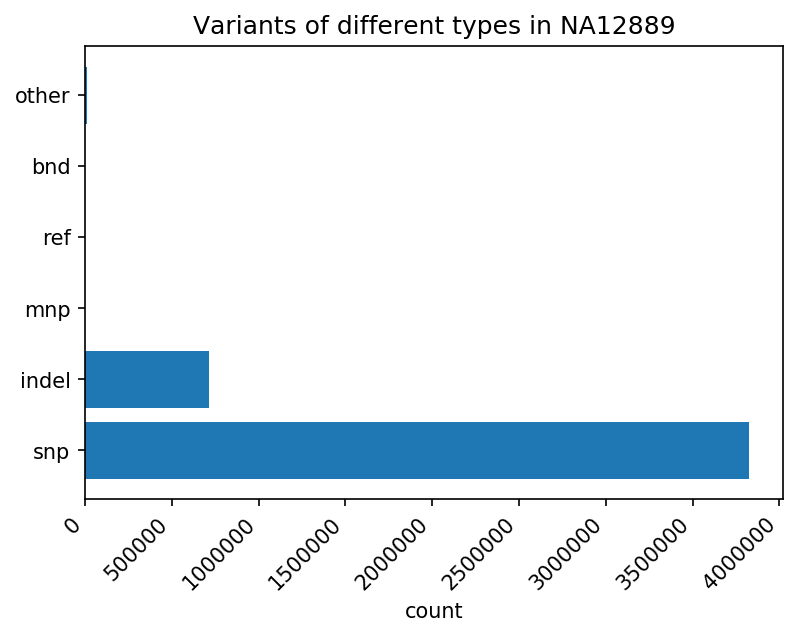

In [22]:
fig = bar_plot(ntypes, var_types, 'Variants of different types in NA12889')
attila_utils.savefig(fig, 'vartype-distrib')

The records in all variant types add up to the total number of biallelic records calculated earlier.  Phew.

In [8]:
{'total': ntot['biallelic'], 'sum of types': sum(ntypes.values()), 'difference': ntot['biallelic'] - sum(ntypes.values())}

{'difference': 0, 'sum of types': 4551757, 'total': 4551757}

### Genotypes

In [9]:
genotypes = ['AA', 'RA', 'RR', 'hap', 'mis']
ngenotypes = {y: ts.count_records('TYPE="snp" && GT=' + '"' + y + '"') for y in genotypes}

['named-figure/genotype-distrib-snp.png',
 'named-figure/genotype-distrib-snp.pdf']

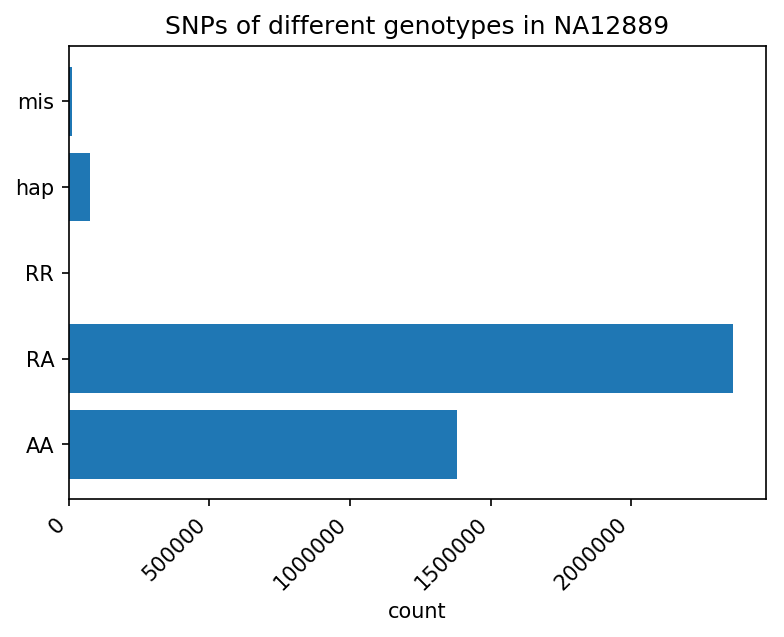

In [24]:
fig = bar_plot(ngenotypes, genotypes, 'SNPs of different genotypes in NA12889')
attila_utils.savefig(fig, 'genotype-distrib-snp')

In [11]:
genotypes = ['AA', 'RA', 'RR', 'hap', 'mis']
ngenotypes_indels = {y: ts.count_records('TYPE="indel" && GT=' + '"' + y + '"') for y in genotypes}

['named-figure/genotype-distrib-indel.png',
 'named-figure/genotype-distrib-indel.pdf']

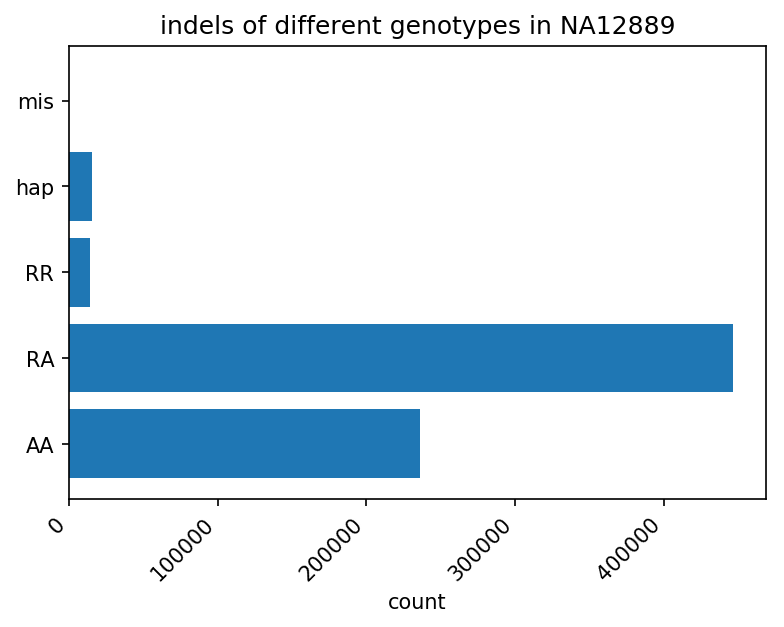

In [25]:
fig = bar_plot(ngenotypes_indels, genotypes, 'indels of different genotypes in NA12889')
attila_utils.savefig(fig, 'genotype-distrib-indel')

## Outline for implementation

Input is two sets of 4 VCFs under `~/projects/bsm/results/calls/ceph-utah/` on attila-ThinkS.
1. `chesslab/NA128{89,90,91,92}.vcf.gz`
1. `illumina/NA128{89,90,91,92}.vcf.gz`

procedures
1. *PASS* filter ($2 \times 4$ VCFs)
1. spit multiallelic into biallelic records ($2 \times 4$ VCFs)
1. take union of `chesslab/NA12889.vcf.gz` with `illumina/NA12889.vcf.gz`
    * Previously we used intersection.  But since we already apply PASS filtering intersection doesn't seem ideal because it removes further records many of which are real variants. Qualitatively speaking, union compensates for the loss of real variants with PASS filter while intersection causes further loss of real variants.
    * the output is one set of 4 VCFs
1. filter each VCF for SNPs or indels resulting in $2 \times 4$ VCFs
1. filter for GT=RA or GT=AA resulting in $2 \times 2 \times 4$ VCFs
1. take set partitions resulting in $80\times 2$ VCFs